# American Football and Machine Learning 
#### netids: cfr59, jah574

**Overview:** Kaggle data

**Dataset:** hhttps://bit.ly/2OxO0Gl

**Research Goal:** To determine the number of yards an NFL rusher will wush for given certain environmental and personal features 

**Methodologies/Approach:**

In [91]:
# import the necessary libraries & modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import seaborn as sns
import datetime
from sklearn.linear_model import Perceptron
from sklearn import cluster
from sklearn.cluster import KMeans

# configure settings
pd.set_option('display.max_columns', 100)

import warnings;
warnings.filterwarnings('ignore');

In [2]:
# import the data
nfl_data = pd.read_csv('nfl_ml.csv', low_memory = False)

In [3]:
nfl_data.head()

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,NflId,DisplayName,JerseyNumber,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,OffenseFormation,OffensePersonnel,DefendersInTheBox,DefensePersonnel,PlayDirection,TimeHandoff,TimeSnap,Yards,PlayerHeight,PlayerWeight,PlayerBirthDate,PlayerCollegeName,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,496723,Eric Berry,29,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-0,212,12/29/1988,Tennessee,SS,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,2495116,Allen Bailey,97,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,288,03/25/1989,Miami,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,3.01,202.73,2495493,Justin Houston,50,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,270,01/21/1989,Georgia,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
3,2017090700,20170907000118,away,71.46,27.70,0.42,0.54,0.02,359.77,105.64,2506353,Derrick Johnson,56,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,245,11/22/1982,Texas,ILB,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
4,2017090700,20170907000118,away,69.32,35.42,1.82,2.43,0.16,12.63,164.31,2530794,Ron Parker,38,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-0,206,08/17/1987,Newberry,FS,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW


## Data Manipulation

Some of the columns are entirely irrelevant to the number of yards rushed; we will remove those columns. 

In [4]:
# drop entirely irrelevant columns (based on our discretion)
nfl_data.drop(['GameId', 'PlayId', 'JerseyNumber', 'Season', 'DisplayName', \
               'Stadium', 'Week', 'Location', 'NflId', \
               'PlayerCollegeName'], axis=1, inplace=True);

#### Number Conversions

In [5]:
# convert time remaining into seconds
def clock(str):
    return int(str[:2]) * 60 + int(str[3:5])

nfl_data['GameClock'] = nfl_data['GameClock'].apply(clock)

In [6]:
# player height into inches
def height(str):
    return int(str[:1]) * 12 + int(str[2:])

nfl_data['PlayerHeight'] = nfl_data['PlayerHeight'].apply(height)

In [7]:
# add BMI column
nfl_data['BMI'] = 703 * nfl_data['PlayerWeight'] / (nfl_data['PlayerHeight'] ** 2)

In [8]:
# time difference between snap and handoff in seconds
nfl_data['TimeSnap'] = nfl_data['TimeSnap'].replace({'T':' ', 'Z':''}, regex=True) 
nfl_data['TimeHandoff'] = nfl_data['TimeHandoff'].replace({'T':' ', 'Z':''}, regex=True) 

def time_delta(row):
    d1 = datetime.datetime.strptime(row['TimeSnap'], '%Y-%m-%d %H:%M:%S.%f')
    d2 = datetime.datetime.strptime(row['TimeHandoff'], '%Y-%m-%d %H:%M:%S.%f')
    t1 = int(d1.strftime('%S'))
    t2 = int(d2.strftime('%S'))
    return t2 - t1 if t2 > t1 else 60 + t2 - t1
    
nfl_data['time_delta'] = nfl_data.apply(lambda row: time_delta(row), axis=1)

In [9]:
# calculate the player's approximate age (only takes year into consideration)
age = []
for i in range(len(nfl_data)):
    d1 = datetime.datetime.strptime(nfl_data['TimeSnap'][i], '%Y-%m-%d %H:%M:%S.%f')
    y = int(d1.strftime('%Y'))
    a = y - int(str(nfl_data['PlayerBirthDate'][i])[-4:])
    age.append(a)
    
nfl_data['ApproxAge'] = age

In [10]:
# make all windspeed values numeric
nfl_data['WindSpeed'] = (pd.to_numeric(nfl_data['WindSpeed'],errors='coerce').fillna(0))

#### String Encoding

In [11]:
def encode(col, d={}):
    '''
    Returns a dictionary that maps column
    to order of occurrence
    Note: linear relationship not established
    '''
    dct = d
    value = 0
    for i in range(len(nfl_data)):
        key = nfl_data[col][i]
        if key not in dct.keys():
            dct.update({key : value})
            value += 1
    
    return dct      

In [12]:
# encode specified columns
cols = ['Team',  \
       'StadiumType', 'Turf', 'GameWeather', 'WindDirection', 'Position', \
       'PlayDirection', 'OffenseFormation', 'OffensePersonnel', 'DefensePersonnel']

for c in cols:
    nfl_data[c].replace(encode(c), inplace=True)

In [13]:
# team dictionary so that teams map to same number over all columns 
d1 = encode('PossessionTeam')
d2 = encode('FieldPosition', d1)
d3 = encode('HomeTeamAbbr', d2)
d4 = encode('VisitorTeamAbbr', d3)

teams = d4

cols = ['PossessionTeam', 'FieldPosition', 'HomeTeamAbbr', 'VisitorTeamAbbr']

for c in cols:
    nfl_data[c].replace(teams, inplace=True)

In [14]:
# remove remaining unnecessary columns
nfl_data.drop(['TimeHandoff', 'TimeSnap', 'PlayerBirthDate'], axis=1, inplace=True)

In [15]:
# replace NaN values with 0
nfl_data.fillna(0, inplace=True)

In [16]:
# the mostly clean dataset
nfl_data.head(8)

,Team,X,Y,S,A,Dis,Orientation,Dir,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,OffenseFormation,OffensePersonnel,DefendersInTheBox,DefensePersonnel,PlayDirection,Yards,PlayerHeight,PlayerWeight,Position,HomeTeamAbbr,VisitorTeamAbbr,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection,BMI,time_delta,ApproxAge
0,0,73.91,34.84,1.69,1.13,0.40,81.99,177.18,35,1,854,4,3,2,4,0,0,2543773,0,0,6.0,0,0,8,72,212,0,4,0,0,0,0,63.0,77.0,8.0,0,28.749228,1,29
1,0,74.67,32.64,0.42,1.35,0.01,27.61,198.70,35,1,854,4,3,2,4,0,0,2543773,0,0,6.0,0,0,8,75,288,1,4,0,0,0,0,63.0,77.0,8.0,0,35.993600,1,28
2,0,74.00,33.20,1.22,0.59,0.31,3.01,202.73,35,1,854,4,3,2,4,0,0,2543773,0,0,6.0,0,0,8,75,270,1,4,0,0,0,0,63.0,77.0,8.0,0,33.744000,1,28
3,0,71.46,27.70,0.42,0.54,0.02,359.77,105.64,35,1,854,4,3,2,4,0,0,2543773,0,0,6.0,0,0,8,75,245,2,4,0,0,0,0,63.0,77.0,8.0,0,30.619556,1,35
4,0,69.32,35.42,1.82,2.43,0.16,12.63,164.31,35,1,854,4,3,2,4,0,0,2543773,0,0,6.0,0,0,8,72,206,3,4,0,0,0,0,63.0,77.0,8.0,0,27.935571,1,30
5,0,75.06,24.00,1.01,0.32,0.18,308.34,95.01,35,1,854,4,3,2,4,0,0,2543773,0,0,6.0,0,0,8,74,252,1,4,0,0,0,0,63.0,77.0,8.0,0,32.351351,1,26
6,0,74.11,16.64,1.11,0.83,0.02,357.23,322.59,35,1,854,4,3,2,4,0,0,2543773,0,0,6.0,0,0,8,71,190,4,4,0,0,0,0,63.0,77.0,8.0,0,26.496727,1,25
7,0,73.37,18.73,1.24,0.74,0.13,328.52,270.04,35,1,854,4,3,2,4,0,0,2543773,0,0,6.0,0,0,8,72,193,4,4,0,0,0,0,63.0,77.0,8.0,0,26.172647,1,26


## Data Visualization

#### Looking at Weight and Height

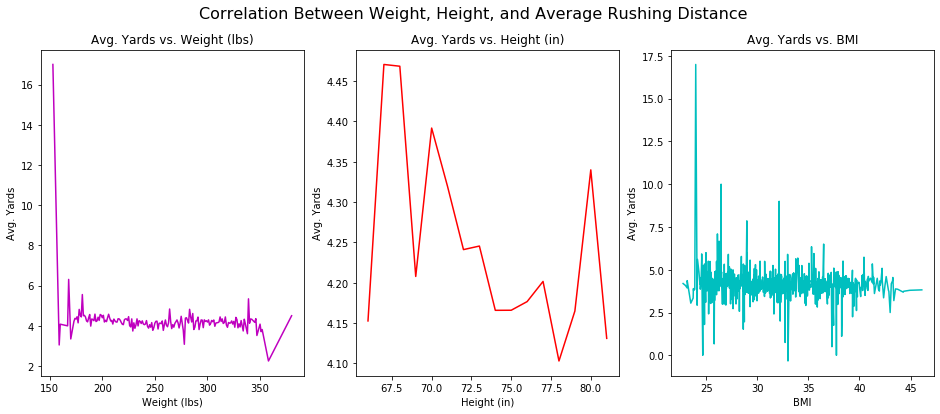

In [17]:
df = nfl_data[['PlayerWeight', 'PlayerHeight', 'BMI', 'Yards']]
df.groupby(df.columns, axis=1).sum().head()

weight = df.groupby('PlayerWeight', as_index=False).agg({'Yards':'mean'})
height = df.groupby('PlayerHeight', as_index=False).agg({'Yards':'mean'})
bmi = df.groupby('BMI', as_index=False).agg({'Yards':'mean'})

fig, ax = plt.subplots(1, 3, figsize=(16,6))
fig.suptitle('Correlation Between Weight, Height, and Average Rushing Distance', fontsize=16)

ax[0].plot(weight['PlayerWeight'], weight['Yards'], 'm')
ax[0].set_title('Avg. Yards vs. Weight (lbs)')
ax[0].set_ylabel('Avg. Yards')
ax[0].set_xlabel('Weight (lbs)')

ax[1].plot(height['PlayerHeight'], height['Yards'], 'r')
ax[1].set_title('Avg. Yards vs. Height (in)')
ax[1].set_ylabel('Avg. Yards')
ax[1].set_xlabel('Height (in)')

ax[2].plot(bmi['BMI'], bmi['Yards'], 'c')
ax[2].set_title('Avg. Yards vs. BMI')
ax[2].set_ylabel('Avg. Yards')
ax[2].set_xlabel('BMI')

plt.show()

In [18]:
nfl_data.drop(['PlayerHeight', 'PlayerWeight', 'BMI'], axis=1, inplace=True)

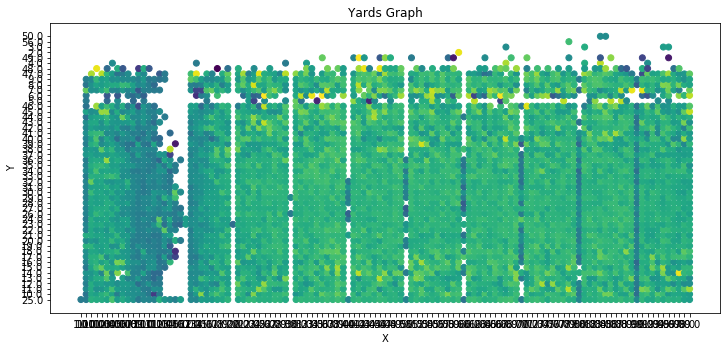

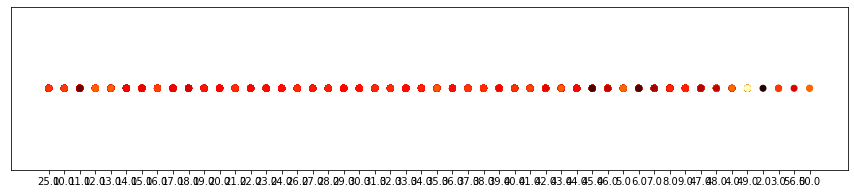

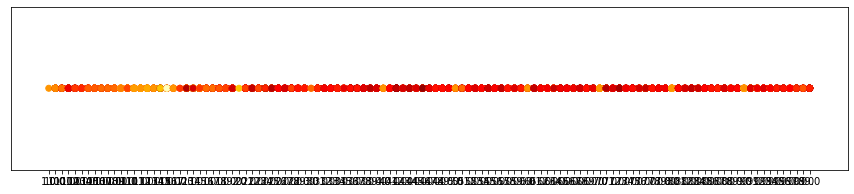

In [93]:
df = nfl_data[['X', 'Y', 'Yards']]
df['X'] = round(df['X'])
df['Y'] = round(df['Y'])
df['XY'] = df['X'].astype(str) + ' ' + df['Y'].astype(str)

df.groupby(df.columns, axis=1).sum().head()
position = df.groupby('XY', as_index=False).agg({'Yards':'mean'})
position = position[abs(position.Yards) < 10] # remove outliers

X = position['XY'].str.split(' ').str[0]
Y = position['XY'].str.split(' ').str[1]
C = position['Yards'].values.ravel()

plt.figure(figsize=(12, 5.33))
plt.scatter(X, Y, c=C)
plt.title('Yards Graph')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

plt.figure(figsize=(15, 3))
plt.scatter(Y, np.zeros_like(Y), c=C, cmap="hot_r")
plt.yticks([])
plt.show()

plt.figure(figsize=(15, 3))
plt.scatter(X, np.zeros_like(X), c=C, cmap="hot_r")
plt.yticks([])
plt.show()

## Machine Learning

In [21]:
def print_metrics(predictions, actual):
    '''
    Prints helpful metrics regarding the accuracy of a ML model 
    for this dataset
    '''
    exact_accuracy = accuracy_score(predictions, actual)
    one_yard_accuracy = sum(abs(predictions - actual) <= 1) / predictions.size
    two_yard_accuracy = sum(abs(predictions - actual) <= 2) / predictions.size
    avg_error = (predictions - actual).sum() / predictions.size
    
    count = 0
    for i in range(predictions.size):
        if predictions[i] >= 0 and actual.iloc[i] >= 0 or \
        predictions[i] <= 0 and actual.iloc[i] <= 0:
            count += 1
    forward_backward_accuracy = count / predictions.size

    print('          accuracy: ', round(100 * exact_accuracy, 2), '%')
    print('   1 yard accuracy: ', round(100 * one_yard_accuracy, 2), '%')
    print('   2 yard accuracy: ', round(100 * two_yard_accuracy, 2), '%')
    print('direction accuracy: ', round(100 * forward_backward_accuracy, 2), '%')
    print('     average error: ', round(avg_error, 2), ' yards')

#### KNN Models

In [22]:
def knn(x_train, x_test, y_train, y_test, train_size=10000, kN=5, verbose=False):
    '''
    Trains a kNN model and returns the predictions and accuracy
    '''
    model = KNeighborsClassifier(n_neighbors=kN)
    model.fit(x_train[:train_size], y_train[:train_size])
    prediction = model.predict(x_test)
    score = accuracy_score(prediction, y_test)

    if verbose:
        print_metrics(prediction, y_test)
    
    return prediction, score

def graph_metrics(x, y):
    '''
    Graphs Model Accuracy vs. # of Nearest Neighbors 
    '''
    plt.scatter(x, y)
    plt.xlabel('# Nearest Neighbors')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. # KNN')
    plt.show()
    
def data_comparison(score, scores, pred, best_pred):
    if len(scores) > 0 and score > max(scores):
        best_pred = pred
    elif len(scores) == 0:
        best_pred = pred
    scores.append(score)
    return scores, best_pred

          accuracy:  15.52 %
   1 yard accuracy:  29.54 %
   2 yard accuracy:  41.98 %
direction accuracy:  84.06 %
     average error:  0.1  yards


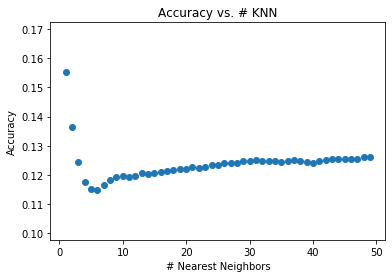

In [23]:
# uses all the data to predict rushing yards
X = nfl_data.drop(['Yards'], axis = 1)
Y = nfl_data['Yards']
x_train1, x_test1, y_train1, y_test1 = train_test_split(X, Y, test_size = 0.25, random_state = 1)

accuracy = []
best_prediction = None
for k in range(1, 50):
    prediction, score = knn(x_train1, x_test1, y_train1, y_test1, kN=k)
    accuracy, best_prediction = data_comparison(score, accuracy, prediction, best_prediction)

print_metrics(best_prediction, y_test1)
graph_metrics(range(1, 50), accuracy)

          accuracy:  23.03 %
   1 yard accuracy:  36.39 %
   2 yard accuracy:  48.28 %
direction accuracy:  85.56 %
     average error:  -0.05  yards


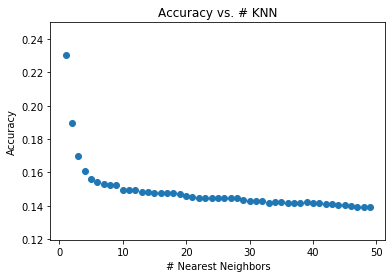

In [24]:
# feature selection to avoid overfitting snd reduce high dimensionality
df = nfl_data.corr()['Yards']
yard_corr = df.loc[(abs(df) > 0.02)]
yard_corr.drop('Yards', axis=0, inplace=True)

# only uses features with above a 0.02 correlation with rushing yards
X = nfl_data[yard_corr.index.values]
Y = nfl_data['Yards']
x_train2, x_test2, y_train2, y_test2 = train_test_split(X, Y, test_size = 0.25, random_state = 1)

accuracy = []
best_prediction = None
for k in range(1, 50):
    prediction, score = knn(x_train2, x_test2, y_train2, y_test2, kN=k)
    accuracy, best_prediction = data_comparison(score, accuracy, prediction, best_prediction)

print_metrics(best_prediction, y_test2)
graph_metrics(range(1, 50), accuracy)

          accuracy:  12.42 %
   1 yard accuracy:  33.48 %
   2 yard accuracy:  50.83 %
direction accuracy:  89.3 %
     average error:  -2.07  yards


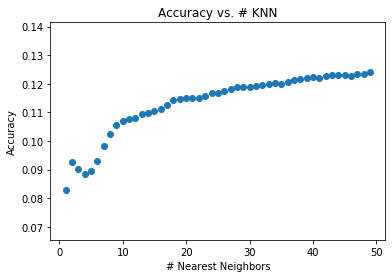

In [25]:
# Only uses rusher location on field and acceleration to predict yardage
X = nfl_data[['X', 'Y', 'A']]
Y = nfl_data['Yards']
x_train4, x_test4, y_train4, y_test4 = train_test_split(X, Y, test_size = 0.25, random_state = 1)

accuracy = []
best_prediction = None
for k in range(1, 50):
    prediction, score = knn(x_train4, x_test4, y_train4, y_test4, kN=k)
    accuracy, best_prediction = data_comparison(score, accuracy, prediction, best_prediction)

print_metrics(best_prediction, y_test2)
graph_metrics(range(1, 50), accuracy)

#### Perceptron

In [26]:
model = Perceptron()

# uses all available data
model.fit(x_train1, y_train1)
predictions = model.predict(x_test1)
print_metrics(predictions, y_test1)

print('\n')

# fewer dimensions
model.fit(x_train2, y_train2)
predictions = model.predict(x_test2)
print_metrics(predictions, y_test2)

          accuracy:  0.09 %
   1 yard accuracy:  0.22 %
   2 yard accuracy:  0.4 %
direction accuracy:  20.79 %
     average error:  -14.1  yards


          accuracy:  10.63 %
   1 yard accuracy:  31.79 %
   2 yard accuracy:  49.81 %
direction accuracy:  81.79 %
     average error:  -1.76  yards


In [27]:
# reduce high dimensionality even a little more
df = nfl_data.corr()['Yards']
yard_corr = df.loc[(abs(df) > 0.025)]
yard_corr.drop('Yards', axis=0, inplace=True)

X = nfl_data[yard_corr.index.values]
Y = nfl_data['Yards']
x_train3, x_test3, y_train3, y_test3 = train_test_split(X, Y, test_size = 0.25, random_state = 1)

model.fit(x_train3, y_train3)
predictions = model.predict(x_test3)
print_metrics(predictions, y_test3)

          accuracy:  11.36 %
   1 yard accuracy:  34.17 %
   2 yard accuracy:  52.89 %
direction accuracy:  88.03 %
     average error:  -1.23  yards


#### SVM

In [28]:
# SVM model. Because of high complexity constant, only training/testing on 750 samples
model = SVC(kernel = 'linear', gamma = 1, C = 1)
model.fit(x_train3[:750], y_train3[:750])
predictions = model.predict(x_test3[:750])
print_metrics(predictions, y_test3[:750])

          accuracy:  10.8 %
   1 yard accuracy:  34.53 %
   2 yard accuracy:  51.73 %
direction accuracy:  90.0 %
     average error:  -2.46  yards


## Conclusions